In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from scipy import stats
from pylab import savefig

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import f1_score, recall_score, accuracy_score, precision_score, make_scorer
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix, plot_confusion_matrix
from sklearn.metrics import roc_curve, classification_report, roc_auc_score, make_scorer
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV

import xgboost as xgb

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from collections import Counter

plt.style.use('ggplot')

import warnings
warnings.filterwarnings("ignore")

#show all columns
pd.set_option('display.max_columns', None)

In [100]:
!ls data

Animal_Shelter_Intake_and_Outcome.csv reg_cat_data.csv
clf_cat_data.csv                      reg_data_cleaned.csv
clf_data_cleaned.csv                  reg_dog_data.csv
clf_dog_data.csv                      reg_other_data.csv
clf_other_data.csv


In [101]:
# Load cleaned datasets:

df_clf = pd.read_csv('data/clf_data_cleaned.csv')
df_reg = pd.read_csv('data/reg_data_cleaned.csv')

# Load separated sub-df's:
    # clf and reg for cats, dogs, and other

In [95]:
def train_smote_clf(df):
    
    y = df['Outcome Type']
    X = df.drop(columns=['Outcome Type', 'Intake Date', 'Unnamed: 0'])
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=15)
    
    sm = SMOTE(random_state=15)
    print('Original dataset shape %s' % Counter(y_train))
    
    X_train, y_train = sm.fit_sample(X_train, y_train)
    print('Resampled dataset shape %s' % Counter(y_train))

    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = train_smote_clf(df_clf)

Original dataset shape Counter({2: 5041, 3: 4745, 1: 2829, 0: 2292})
Resampled dataset shape Counter({2: 5041, 0: 5041, 1: 5041, 3: 5041})


In [46]:
def run_rf_clf(X_train, X_test, y_train, y_test, n_estimators=1000, max_features='auto', max_depth=100):
    rf = RandomForestClassifier(n_estimators=n_estimators,
                               max_features=max_features,
                                max_depth=max_depth,
                               n_jobs=-1,
                               random_state=10)
    
    rf.fit(X_train, y_train)
    pred = rf.predict(X_test)
    
    # Accuracy
    print(f"accuracy = {rf.score(X_test, y_test)}")

    # f1 score
    print("F1 score:", f1_score(y_test, pred, average='weighted'))

    # recall score
    print("Recall score:", recall_score(y_test, pred, average='weighted'))
    
    # scores by class
    print(classification_report(y_test, pred, digits=4))
    
    # confusion matrix to calculate accuracy per class
    matrix = confusion_matrix(y_test, pred)
    acc_per_class = matrix.diagonal()/matrix.sum(axis=0)

    print('Accuracy per class:', acc_per_class)
    
    # plot confusion matrix
    plot_confusion_matrix(rf, X_test, y_test)
    plt.show()
    
    feat_scores = pd.DataFrame({'Fraction of Samples Affected' : rf.feature_importances_},
                           index=X_train.columns)
    feat_scores = feat_scores.sort_values(by='Fraction of Samples Affected', ascending=False)
    feat_scores[:30].plot(kind='barh', figsize=(10,10))

accuracy = 0.7611189374119541
F1 score: 0.7597293558113939
Recall score: 0.7611189374119541
              precision    recall  f1-score   support

           0     0.8098    0.7749    0.7920       764
           1     0.6861    0.6119    0.6469       943
           2     0.7628    0.8073    0.7844      1681
           3     0.7763    0.7944    0.7852      1581

    accuracy                         0.7611      4969
   macro avg     0.7587    0.7471    0.7521      4969
weighted avg     0.7598    0.7611    0.7597      4969

Accuracy per class: [0.80984952 0.68608799 0.76278808 0.776267  ]


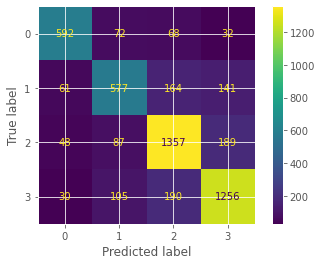

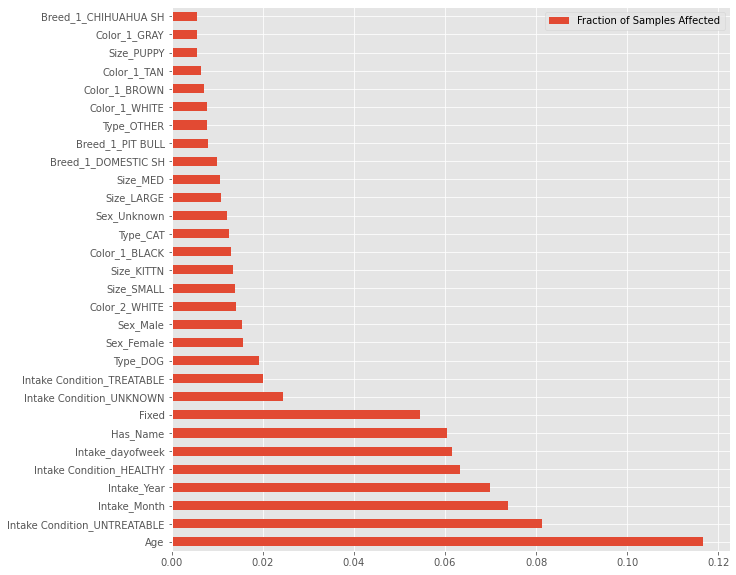

In [47]:
run_rf_clf(X_train, X_test, y_train, y_test)

## Try Gradient Boosting Classifier instead of RF?
- Run GridSearchCV to find optimal parameters

In [30]:
# gradient_boosting_grid = {'learning_rate': [0.1, 0.05],\
#                           'max_depth': [4, 6, 8],\
#                           'min_samples_leaf': [5, 10],\
#                           'max_features': [0.5, 0.3],\
#                           'n_estimators': [500],\
#                           'random_state': [1]}

# gb_gridsearch = GridSearchCV(GradientBoostingClassifier(),
#                                 gradient_boosting_grid,
#                                 n_jobs=-1,
#                                 verbose=True,
#                                 cv=3,
#                                 scoring='recall_weighted'
#                                 )

# gb_gridsearch.fit(X_train, y_train)

# best_gb_model = gb_gridsearch.best_params_
# best_gb_model

# {'learning_rate': 0.1,
#  'max_depth': 6,
#  'max_features': 0.3,
#  'min_samples_leaf': 10,
#  'n_estimators': 500,
#  'random_state': 1}

Fitting 3 folds for each of 108 candidates, totalling 324 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed: 48.9min
[Parallel(n_jobs=-1)]: Done 324 out of 324 | elapsed: 89.1min finished


In [48]:
# Gradient Boosting Classifier - better scores than RF but XGBoost is better
model = GradientBoostingClassifier(learning_rate=0.1, max_depth=6,\
                                        max_features=0.3, min_samples_leaf=10,\
                                        n_estimators=500, random_state=1)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

print('accuracy =', accuracy_score(y_test, y_pred))
print('recall =', recall_score(y_test, y_pred, average='weighted'))
print('precision =', precision_score(y_test, y_pred, average='weighted'))
# print('auc =', roc_auc_score(y_test, y_pred, average='weighted'))
print(classification_report(y_test, y_pred))

accuracy = 0.7830549406319179
recall = 0.7830549406319179
precision = 0.7811657475951577
              precision    recall  f1-score   support

           0       0.83      0.79      0.81       764
           1       0.71      0.61      0.66       943
           2       0.79      0.83      0.81      1681
           3       0.79      0.83      0.81      1581

    accuracy                           0.78      4969
   macro avg       0.78      0.77      0.77      4969
weighted avg       0.78      0.78      0.78      4969



## Try XG Boost
- This seems to yield the best recall scores for the two classes that matter most - class 3 (adoption) and class 0 (euthanize)

In [49]:
def run_xgb_clf(X_train, X_test, y_train, y_test,
                learning_rate=0.05, max_depth=10, n_estimators=500):

    '''
    Input: X_train, X_test, y_train, y_test after running SMOTE to balance X_train and y_train ONLY.
    Optimal hyperparameters from gridsearchCV has been set to default.

    Output:
    Model will fit, predict, and print various scores as well as the confusion matrix. 
    Precision score and recall score are weighted.
    '''

    xgb_model = xgb.XGBClassifier(learning_rate=0.05,
                                max_depth = 10, 
                                n_estimators = 500)

    xgb_model.fit(X_train, y_train)

    xgb_predict=xgb_model.predict(X_test)


    print("Confusion Matrix: \n", confusion_matrix(y_test,xgb_predict))

    print("Precision = {}".format(precision_score(y_test, xgb_predict, average='weighted')))
    print("Recall = {}".format(recall_score(y_test, xgb_predict, average='weighted')))
    print("Accuracy = {}".format(accuracy_score(y_test, xgb_predict)))

    print("\n classification report by class: \n", classification_report(y_test, xgb_predict, digits=3))

    matrix = confusion_matrix(y_test, xgb_predict)
    acc_per_class = matrix.diagonal()/matrix.sum(axis=0)

    print('Accuracy per class:', acc_per_class)

[[ 599   66   68   31]
 [  52  580  147  164]
 [  39   91 1390  161]
 [  26   76  134 1345]]
              precision    recall  f1-score   support

           0       0.84      0.78      0.81       764
           1       0.71      0.62      0.66       943
           2       0.80      0.83      0.81      1681
           3       0.79      0.85      0.82      1581

    accuracy                           0.79      4969
   macro avg       0.79      0.77      0.78      4969
weighted avg       0.79      0.79      0.79      4969

Precision = 0.7860040276635091
Recall = 0.7876836385590662
Accuracy = 0.7876836385590662

 classification report by class: 
               precision    recall  f1-score   support

           0     0.8366    0.7840    0.8095       764
           1     0.7134    0.6151    0.6606       943
           2     0.7993    0.8269    0.8129      1681
           3     0.7907    0.8507    0.8196      1581

    accuracy                         0.7877      4969
   macro avg     0.78

In [ ]:
# ROUND 1
# param_grid = {'max_depth': [8, 10, 15, 20],
#                       'learning_rate': [0.1, 0.01, 0.05],
#                       'gamma': [0, 0.25, 0.5, 1.0],
#                       'reg_lambda': [0, 1.0, 10.0],
#                     'scale_pos_weight': [1, 3, 5] }
# best parameters: {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 20, 'reg_lambda': 0, 'scale_pos_weight': 1}


# ROUND 2
# param_grid = {'max_depth': [10, 15, 20, 25],
#             'learning_rate': [0.1, 0.05],
#             'n_estimators': [100, 200, 500]
#              }
# best parameters: {'learning_rate': 0.05, 'max_depth': 25, 'n_estimators': 500}***
## Still not better than the model that was optimized via trial and error


# gb_gridsearch = GridSearchCV(xgb.XGBClassifier(objective='gbtree',
#                                               seed=42,
#                                               subsample=0.9,
#                                               colsample_bytree=.7),
#                              param_grid=param_grid,
#                              verbose=4,
#                              scoring='recall_weighted',
#                             n_jobs = -1,
#                             cv =3)

# gb_gridsearch.fit(X_train, y_train)
# print ("best parameters:", gb_gridsearch.best_params_)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.


In [96]:
# TRY with scale_pos_weight

xgb_model = xgb.XGBClassifier(learning_rate=0.05,
                                max_depth = 10, 
                                n_estimators = 500, scale_pos_weight=0.5)

xgb_model.fit(X_train, y_train)

xgb_predict=xgb_model.predict(X_test)


print("Confusion Matrix: \n", confusion_matrix(y_test,xgb_predict))

print("Precision = {}".format(precision_score(y_test, xgb_predict, average='weighted')))
print("Recall = {}".format(recall_score(y_test, xgb_predict, average='weighted')))
print("Accuracy = {}".format(accuracy_score(y_test, xgb_predict)))

print("\n classification report by class: \n", classification_report(y_test, xgb_predict, digits=3))

matrix = confusion_matrix(y_test, xgb_predict)
acc_per_class = matrix.diagonal()/matrix.sum(axis=0)

print('Accuracy per class:', acc_per_class)

[15:20:40] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Confusion Matrix: 
 [[ 599   66   68   31]
 [  52  580  147  164]
 [  39   91 1390  161]
 [  26   76  134 1345]]
Precision = 0.7860040276635091
Recall = 0.7876836385590662
Accuracy = 0.7876836385590662

 classification report by class: 
               precision    recall  f1-score   support

           0      0.837     0.784     0.809       764
           1      0.713     0.615     0.661       943
           2      0.799     0.827     0.813      1681
           3      0.791     0.851     0.820      1581

    accuracy                          0.788      4969
   macro avg      0.785     0.769     0.7

In [102]:
# Without SMOTE?

y = df_clf['Outcome Type']
X = df_clf.drop(columns=['Outcome Type', 'Intake Date', 'Unnamed: 0'])

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=15)

xgb_model = xgb.XGBClassifier(learning_rate=0.05,
                                max_depth = 10, 
                                n_estimators = 500, scale_pos_weight=0.5)

xgb_model.fit(X_train, y_train)

xgb_predict=xgb_model.predict(X_test)


print("Confusion Matrix: \n", confusion_matrix(y_test,xgb_predict))

print("Precision = {}".format(precision_score(y_test, xgb_predict, average='weighted')))
print("Recall = {}".format(recall_score(y_test, xgb_predict, average='weighted')))
print("Accuracy = {}".format(accuracy_score(y_test, xgb_predict)))

print("\n classification report by class: \n", classification_report(y_test, xgb_predict, digits=3))

matrix = confusion_matrix(y_test, xgb_predict)
acc_per_class = matrix.diagonal()/matrix.sum(axis=0)

print('Accuracy per class:', acc_per_class)

[16:59:37] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Confusion Matrix: 
 [[ 584   66   81   33]
 [  43  567  164  169]
 [  30   65 1417  169]
 [  17   51  148 1365]]
Precision = 0.7919050918082114
Recall = 0.7915073455423627
Accuracy = 0.7915073455423627

 classification report by class: 
               precision    recall  f1-score   support

           0      0.866     0.764     0.812       764
           1      0.757     0.601     0.670       943
           2      0.783     0.843     0.812      1681
           3      0.786     0.863     0.823      1581

    accuracy                          0.792      4969
   macro avg      0.798     0.768     0.7

accuracy = 0.7711813242101027
F1 score: 0.7681720655658067
Recall score: 0.7711813242101027
              precision    recall  f1-score   support

           0     0.8791    0.7421    0.8048       764
           1     0.7415    0.5748    0.6476       943
           2     0.7525    0.8412    0.7944      1681
           3     0.7637    0.8280    0.7945      1581

    accuracy                         0.7712      4969
   macro avg     0.7842    0.7465    0.7603      4969
weighted avg     0.7734    0.7712    0.7682      4969

Accuracy per class: [0.87906977 0.74145007 0.75252794 0.76371062]


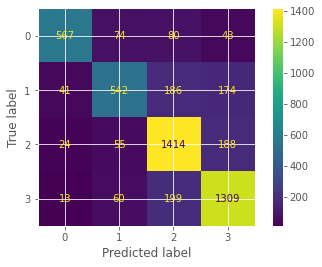

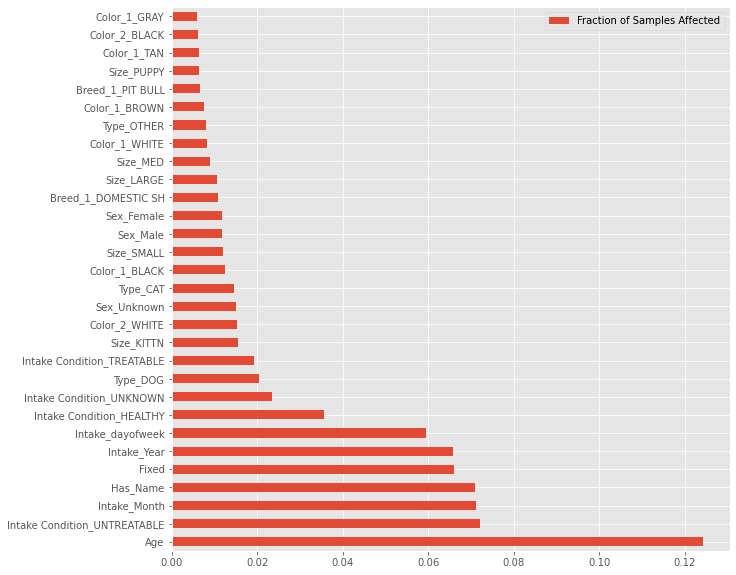

In [103]:
# RF without SMOTE:
run_rf_clf(X_train, X_test, y_train, y_test)

# Regressor Model
- Random Forest Regressor
- XG Boost Regressor

In [50]:
def run_rf_reg(df, n_estimators=100, criterion='mae'):
    
    # Set up train and test sets
    y = df['Days in Shelter']
    X = df.drop(columns=['Days in Shelter', 'Intake Date', 'Unnamed: 0'])
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=15)
    
    # Print baseline MAE score
    baseline_errors = abs(y_test - y_test.mean())
    print('Average baseline error: ', round(np.mean(baseline_errors), 2))
    
    # Set up RF Regressor and run
    regr = RandomForestRegressor(n_estimators=n_estimators, criterion=criterion,
                            n_jobs=-1, verbose=2, random_state=13)
    # Train and predict
    regr.fit(X_train, y_train)
    pred = regr.predict(X_test)
    
    # Print metrics
    print('Mean Absolute Error (MAE):', mean_absolute_error(y_test, pred))
    print('Mean Squared Error (MSE):', mean_squared_error(y_test, pred))
    print('Root Mean Squared Error (RMSE):', np.sqrt(mean_squared_error(y_test, pred)))
    
    # Plot feature importances
    feat_scores = pd.DataFrame({'Fraction of Samples Affected' : regr.feature_importances_},
                           index=X.columns)
    feat_scores = feat_scores.sort_values(by='Fraction of Samples Affected', ascending=False)
    feat_scores[:30].plot(kind='barh', figsize=(10,10))
    plt.show()

Average baseline error:  16.33


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 6 concurrent workers.


building tree 1 of 100building tree 2 of 100

building tree 3 of 100building tree 4 of 100building tree 5 of 100

building tree 6 of 100

building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100


[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:  6.8min


building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 22.8min finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed:    0.0s finished


Mean Absolute Error (MAE): 12.00722579995975
Mean Squared Error (MSE): 604.3082604799758
Root Mean Squared Error (RMSE): 24.582682125430818


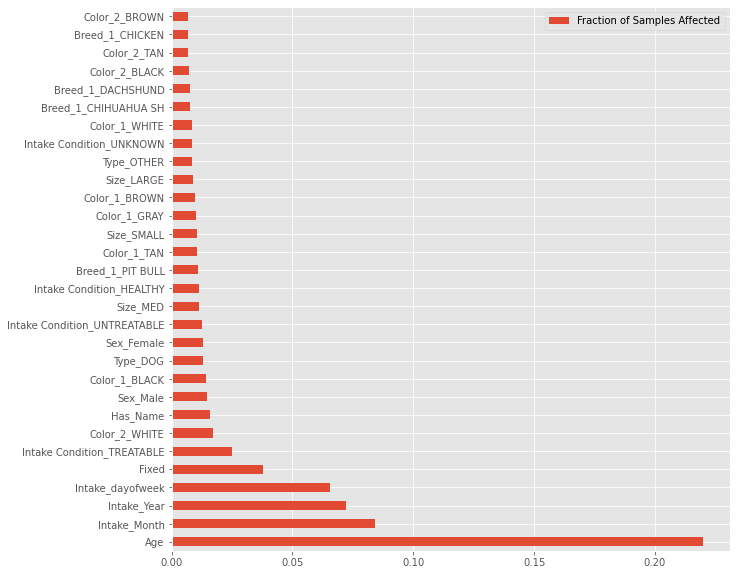

In [51]:
run_rf_reg(df_reg)

#Baseline MAE: 16.33
#RF MAE: 12.74 with n=20
#RF MAE: 12.01 with n=100

In [76]:
def run_xgb_reg(df, booster='gbtree', colsample_bytree=0.8, learning_rate=0.05, max_depth=100, alpha=8):
    '''
    Input: df_reg which includes the target variable: "Days in Shelter". Model will train_test_split, fit the model, and evaluate.
    
    Output: Baseline Mean Absolute Error (MAE), XG Boost MAE, and percent decrease.
    '''
    # Set up train and test sets
    y = df_reg['Days in Shelter']
    X = df_reg.drop(columns=['Days in Shelter', 'Intake Date', 'Unnamed: 0'])

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=15)

    # Print baseline MAE score
    baseline_errors = abs(y_test - y_test.mean())
    print('Average baseline error: ', round(np.mean(baseline_errors), 2))

    # Set up XG Boost Regressor model
    xg_reg = xgb.XGBRegressor(booster=booster, colsample_bytree=colsample_bytree, learning_rate=learning_rate,
                    max_depth=max_depth, alpha=alpha)

    xg_reg.fit(X_train,y_train, verbose=True,
               early_stopping_rounds = 10,
               eval_metric='mae',
               eval_set=[(X_test, y_test)])

    #Best Result (output):
    # XGBRegressor(alpha=8, base_score=0.5, booster='gbtree', colsample_bylevel=1,
    #              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
    #              importance_type='gain', interaction_constraints='',
    #              learning_rate=0.05, max_delta_step=0, max_depth=100,
    #              min_child_weight=1, missing=nan, monotone_constraints='()',
    #              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
    #              reg_alpha=8, reg_lambda=1, scale_pos_weight=1, subsample=1,
    #              tree_method='exact', validate_parameters=1, verbosity=None))

    # validation_0-mae:11.29392******** --- 31% decrease in MAE

    preds = xg_reg.predict(X_test)
    
    MAE = mean_absolute_error(y_test, preds)
    # Print metrics
    print('Mean Absolute Error (MAE):', MAE)
    print('% decrease from baseline MAE: ', (baseline_errors - MAE) / baseline_errors)
#     print('Mean Squared Error (MSE):', mean_squared_error(y_test, preds))
#     print('Root Mean Squared Error (RMSE):', np.sqrt(mean_squared_error(y_test, preds)))

[0]	validation_0-mae:15.86997
Will train until validation_0-mae hasn't improved in 10 rounds.
[1]	validation_0-mae:15.39512
[2]	validation_0-mae:14.96302
[3]	validation_0-mae:14.58779
[4]	validation_0-mae:14.22040
[5]	validation_0-mae:13.90922
[6]	validation_0-mae:13.61806
[7]	validation_0-mae:13.36381
[8]	validation_0-mae:13.14038
[9]	validation_0-mae:12.94300
[10]	validation_0-mae:12.73637
[11]	validation_0-mae:12.56123
[12]	validation_0-mae:12.38904
[13]	validation_0-mae:12.25998
[14]	validation_0-mae:12.11999
[15]	validation_0-mae:12.00814
[16]	validation_0-mae:11.91379
[17]	validation_0-mae:11.82372
[18]	validation_0-mae:11.74550
[19]	validation_0-mae:11.67389
[20]	validation_0-mae:11.62077
[21]	validation_0-mae:11.57213
[22]	validation_0-mae:11.51046
[23]	validation_0-mae:11.45534
[24]	validation_0-mae:11.41263
[25]	validation_0-mae:11.37727
[26]	validation_0-mae:11.35425
[27]	validation_0-mae:11.33836
[28]	validation_0-mae:11.33214
[29]	validation_0-mae:11.31590
[30]	validation_

XGBRegressor(alpha=8, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=100,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=8, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

# Conclusion:

### XG Boost Classifier to predict outcome (euthanize, transfer, return, adoption):
- Final recall scores by class (performs better without SMOTE):
    - 0 (euthanize, died): 0.764 (0.784 with SMOTE)
    - 1 (transfer to another shelter): 0.601 (0.615 with SMOTE)
    - 2 (return to owner): 0.843 (0.827 with SMOTE)
    - 3 (adoption): 0.863 (0.851 with SMOTE)
    
    > SMOTE gives a higher recall score for class 0 (euthanize) by 2%, but lower recall for classes 2 and 3 (return to owner, and adoption). To maximize the adoption prediction, NOT using SMOTE seems to give us a better model.

    
    Recall score seems to be particularly low for class 1 (transfer), perhaps because animals are transferred based on the shelter capacity and other shelters' rather than for animals with specific characteristics.
    
    In terms of importance, class 3 (adoption) and class 0 (euthanize) are what matter most.
    
- Most important features in order:
    - Age
    - Intake condition
    - Fixed (spayed or neutered)
    - Has name
    - Intake date
    - Type: Dog
    - Size: Kitten
    
### XG Boost Regressor to predict number of days spent in shelter:
- Baseline Mean Absolute Error (MAE) is 16.33
- The model's MAE is 11.29, which is a 31% decrease from the baseline


- Most important features in order:
    - Age
    - Intake Date
    - Fixed (spayed or neutered)
    - Intake condition
    - Has name
    - Color: white
    

- Most important features for Type - Cat:
    - Age
    - Has name
    - Intake date
    - Fixed
    - Intake condition


- Most important features for Type - Dog:
    - Age
    - Has name
    - Intake date
    - Fixed
    - Intake condition
    
    
- Most important features for Type - Other:
    - Intake date
    - Age
    - Sex
    - Intake condition
    - Fixed